In [49]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import pandas_datareader as pdr
import matplotlib.pyplot as plt

from statsmodels.regression.rolling import RollingOLS
from pandas.tseries.offsets import MonthEnd


# 데이터 불러오기, 전처리

In [50]:
'''Value Weighted 인지'''
#df = pd.read_csv('./DATA/Industry_Portfolio_monthly_equal_weighted.csv', index_col=0, parse_dates=True)
df = pd.read_csv('./DATA/Industry_Portfolio_monthly_value_weighted.csv', index_col=0, parse_dates=True)
df.index = [dt.datetime.strptime(x, '%Y%m') + MonthEnd() for x in df.index.astype(str)]
df.columns = [x.replace(' ', '') for x in df.columns]
df = df.replace(-99.99, np.NaN).dropna()
df = df[['Oil','Agric', 'Mines', 'Gold', 'Steel']]

'''Value Weighted를 위한 사이즈'''
df_size = pd.read_csv('./DATA/Industry_Portfolio_monthly_firm_size.csv', index_col=0, parse_dates=True)
df_size.index = [dt.datetime.strptime(x, '%Y%m') + MonthEnd() for x in df_size.index.astype(str)]
df_size.columns = [x.replace(' ', '') for x in df_size.columns]
df_size = df_size.replace(-99.99, np.NaN).dropna()
df_size = df_size[['Oil','Agric', 'Mines', 'Gold', 'Steel']].apply(lambda x : x/x.sum(), axis=1)

com_df = pd.read_csv('./DATA/Commodity_index.csv', index_col=0, parse_dates=True).sort_index()
com_df = com_df.resample('m').last()
com_df.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in com_df.index]

spx = pd.read_csv('./DATA/SPX500.csv', index_col=0, parse_dates=True)
spx = spx.resample('m').last()
spx.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in spx.index]

rf = pdr.get_data_fred('DGS10', start="1970-01-01", end='2023-05-18').astype(float).rename(columns={'DGS10':'rf'})
rf = rf.resample('m').last()
rf.index = [dt.datetime.strptime(f"{x.year}-{x.month}", '%Y-%m') + MonthEnd() for x in rf.index]

# Broad NRE vs Broad Replicate 비교
## Replicate 는 변수 PNL로 씀

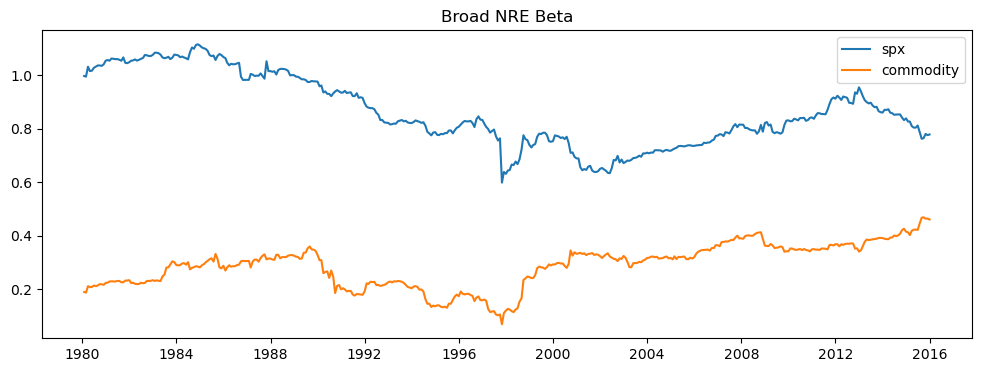

In [51]:
broad_nre = pd.DataFrame(df.mean(axis=1), columns=['NRE']).apply(lambda x: x/100)
#broad_nre = pd.DataFrame(np.diag(df @ df_size.T), index=df_size.index, columns=['NRE']).apply(lambda x:x/100)

broadcom_ret = com_df.pct_change().Broad.dropna()
#broadcom_ret = pd.DataFrame(com_df.iloc[:, 0:4].pct_change().mean(axis=1))
broadcom_ret.columns = ['Broad']

idx_ret = spx.pct_change().dropna()

test = pd.concat([broad_nre, idx_ret, broadcom_ret], axis=1).dropna()

x = test.iloc[:, 1:]
x = sm.add_constant(x)
y = test.iloc[:, 0]

reg = RollingOLS(y, x, window=120).fit()

reg.params.iloc[:, 1:].dropna()

plt.figure(figsize=(12, 4))
plt.title('Broad NRE Beta')
plt.plot(reg.params['SPX'].loc[:'2015'].dropna(), label='spx')
plt.plot(reg.params['Broad'].loc[:'2015'].dropna(), label='commodity')
plt.legend()
plt.show()

In [52]:
print('''Mean Beta''')
reg.params.iloc[:, 1:].mean()

Mean Beta


SPX      0.851748
Broad    0.308291
dtype: float64

In [53]:
print('''Mean T_stat''')
pd.DataFrame(reg.tvalues, index=reg.params.index, columns=reg.params.columns).dropna().iloc[:,1:].mean()

Mean T_stat


SPX      10.535696
Broad     4.924661
dtype: float64

In [54]:
print('''mean R''')
print(f'mean R : {reg.rsquared.mean()}')
print(f'mean R adj : {reg.rsquared_adj.mean()}')

mean R
mean R : 0.5858040461823459
mean R adj : 0.5787237734675138


In [55]:
broad_betas = reg.params.dropna().iloc[:,1:]
broad_betas

,SPX,Broad
1980-01-31,0.996465,0.189941
1980-02-29,0.994122,0.187366
1980-03-31,1.030940,0.211498
1980-04-30,1.014763,0.207965
1980-05-31,1.016318,0.208498
...,...,...
2022-11-30,0.776664,0.402458
2022-12-31,0.778201,0.402332
2023-01-31,0.808963,0.394372
2023-02-28,0.814585,0.392043


## replicate port

### $$ \beta_{\text{SI}}\quad \beta_{\text{CI}}\quad(1-\beta_{\text{SI}}-\beta_{\text{CI}})$$

In [56]:
broad_betas['cash'] = broad_betas.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()
'''다음기 수익률 매핑'''
ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[broad_betas.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
ret_df.rf = ret_df.rf.apply(lambda x: x/12)
ret_df

,SPX,Broad,rf
1980-01-31,-0.004380,-0.011959,0.010600
1980-02-29,-0.101795,-0.127618,0.010533
1980-03-31,0.041140,0.038433,0.008967
1980-04-30,0.046571,0.059591,0.008542
1980-05-31,0.026969,0.067799,0.008408
...,...,...,...
2022-11-30,-0.058971,-0.017770,0.003233
2022-12-31,0.061753,-0.006581,0.002933
2023-01-31,-0.026112,-0.039916,0.003267
2023-02-28,0.035052,-0.013477,0.002900


교과서 있는거랑 비교

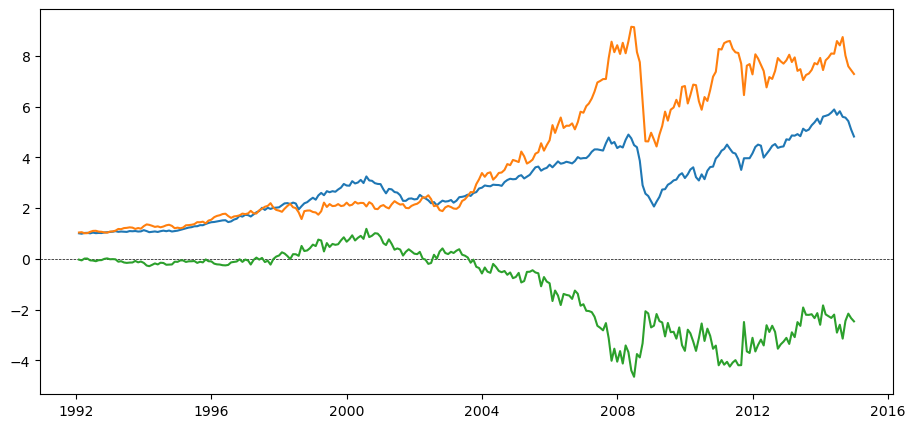

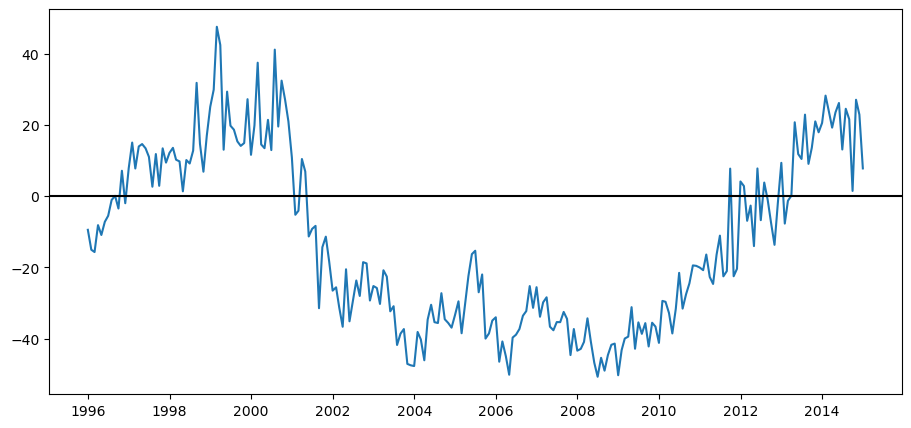

In [57]:
broad_pnl = pd.DataFrame(np.diag(ret_df @ broad_betas.values.T), columns=['pnl'], index=ret_df.index)
ex_broad_cum_ret = (1+broad_pnl.loc['1992':'2014']).cumprod() - (1+broad_nre.loc['1992':'2014']).cumprod().values

plt.figure(figsize=(11,5))
plt.plot((1+broad_pnl.loc['1992':'2014']).cumprod())
plt.plot((1+broad_nre.loc['1992':'2014']).cumprod())
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.plot(ex_broad_cum_ret)

test = (broad_pnl - broad_nre.loc[broad_pnl.index].values)

plt.figure(figsize=(11,5))
plt.plot(((test.loc['1993':'2014'] + 1).rolling(36).apply(pd.Series.prod) - 1).apply(lambda x: x*100).dropna())
plt.axhline(0, color='k')
plt.show()


stats

In [58]:
'''nre period all : 1980-01-31 ~ 2023-03-31'''
broad_nre_returns = (broad_nre.loc[broad_pnl.index].mean() * 12 * 100).item()
broad_nre_vol = np.sqrt(broad_nre.loc[broad_pnl.index].var() * 12).item() * 100
broad_nre_sharpe = ((broad_nre.loc[broad_pnl.index] - rf.loc[broad_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_nre_vol

print('***** Broad NRE STATS (1980-01-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_nre_returns, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_nre_vol, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_nre_sharpe, 5)}')


***** Broad NRE STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 11.75%
Broad NRE Volatility : 21.04%
Broad NRE Sharpe : 0.28735


In [59]:
'''nre period all : 1980-01-31 ~ 2023-03-31'''
broad_pnl_returns = (broad_pnl.mean() * 12 * 100).item()
broad_pnl_vol = np.sqrt(broad_pnl.var() * 12).item() * 100
broad_pnl_sharpe = ((broad_pnl - rf.loc[broad_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_pnl_vol

print('***** Broad Replicate STATS (1980-01-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_pnl_returns, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_pnl_vol, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_pnl_sharpe, 5)}')


***** Broad Replicate STATS (1980-01-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.8%
Broad NRE Volatility : 16.27%
Broad NRE Sharpe : 0.18988


In [60]:
'''nre period all : 2011-03-31 ~ 2023-03-31'''
broad_nre_returns_2 = (broad_nre.loc['2011-03-31':].mean() * 12 * 100).item()
broad_nre_vol_2 = np.sqrt(broad_nre.loc['2011-03-31':].var() * 12).item() * 100
broad_nre_sharpe_2 = ((broad_nre.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100)  / broad_nre_vol_2

print('***** Broad NRE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_nre_returns_2, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_nre_vol_2, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_nre_sharpe_2, 5)}')

***** Broad NRE STATS (2011-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.95%
Broad NRE Volatility : 22.44%
Broad NRE Sharpe : 0.30221


In [61]:
'''Replicate period all : 2011-03-31 ~ 2023-03-31'''
broad_pnl_returns_2 = (broad_pnl.loc['2011-03-31':].mean() * 12 * 100).item()
broad_pnl_vol_2 = np.sqrt(broad_pnl.loc['2011-03-31':].var() * 12).item() * 100
broad_pnl_sharpe_2 = ((broad_pnl.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / broad_pnl_vol_2

print('***** Broad Replicate STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'Broad NRE Performance : {np.round(broad_pnl_returns_2, 2)}%')
print(f'Broad NRE Volatility : {np.round(broad_pnl_vol_2, 2)}%')
print(f'Broad NRE Sharpe : {np.round(broad_pnl_sharpe_2, 5)}')


***** Broad Replicate STATS (2011-03-31 ~ 2023-03-31) *****
Broad NRE Performance : 8.24%
Broad NRE Volatility : 17.8%
Broad NRE Sharpe : 0.34121


# Oil NRE vs Oil Replicate 비교
## Replicate 는 변수 PNL로 씀
### 다른 섹터는 df 변수를 바꿔서 쓰면 됨 (com_df 에는 Commodity 있음)

In [62]:
df

,Oil,Agric,Mines,Gold,Steel
1969-07-31,-9.73,-8.71,-6.31,-20.73,-6.52
1969-08-31,6.60,4.58,3.74,10.10,0.39
1969-09-30,-9.71,1.14,1.11,5.11,-1.04
1969-10-31,-1.17,16.22,4.68,-10.04,8.16
1969-11-30,-4.57,-2.30,0.88,-3.14,-4.58
...,...,...,...,...,...
2022-11-30,0.82,2.53,20.30,12.05,13.90
2022-12-31,-4.04,-12.14,-4.84,0.58,-7.63
2023-01-31,2.84,10.00,16.61,12.22,22.17
2023-02-28,-6.99,-3.35,-3.54,-17.55,2.12


In [63]:
'''Oil'''
oil_nre = df[['Oil']].apply(lambda x: x/100)
oil = pd.concat([oil_nre, com_df[['Pet']].pct_change(), spx.pct_change() ], axis=1).dropna()

x_oil = sm.add_constant(oil.iloc[:,1:])
y_oil = oil.iloc[:, [0]]

oil_reg = RollingOLS(y_oil, x_oil, 120).fit()
oil_reg = oil_reg.params.dropna().iloc[:, 1:]

oil_reg

,Pet,SPX
1993-01-31,0.257558,0.785186
1993-02-28,0.257901,0.785661
1993-03-31,0.256896,0.784817
1993-04-30,0.255342,0.776350
1993-05-31,0.255782,0.778622
...,...,...
2022-11-30,0.387230,0.901490
2022-12-31,0.388173,0.895064
2023-01-31,0.389498,0.886632
2023-02-28,0.390156,0.890988


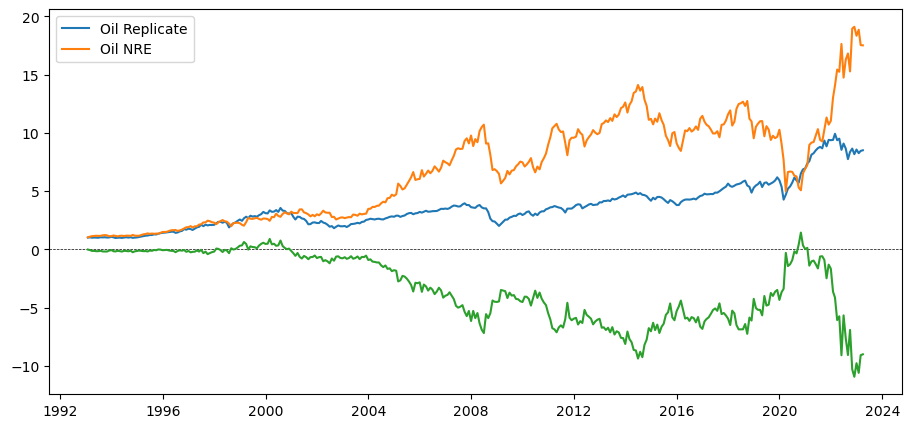

In [64]:
oil_reg['cash'] = oil_reg.apply(lambda x : (1-x.iloc[0]-x.iloc[1]), axis=1).copy()

oil_ret_df = pd.concat([spx.pct_change(), com_df[['Broad']].pct_change(), rf.apply(lambda x: x/100)], axis=1).dropna().shift(-1).loc[oil_reg.index]
'''rf 수익률 사용할 때 1달 투자니 x/12로 해야함'''
oil_ret_df.rf = oil_ret_df.rf.apply(lambda x: x/12)

oil_pnl = pd.DataFrame(np.diag(oil_ret_df @ broad_betas.values.T), columns=['pnl'], index=oil_ret_df.index)
cum_oil_pnl = (oil_pnl + 1).cumprod()
cum_oil_nre = (oil_nre.loc[oil_ret_df.index] + 1).cumprod()
ex_oil_cum_ret = cum_oil_pnl - cum_oil_nre.values

plt.figure(figsize=(11,5))
plt.plot(cum_oil_pnl, label='Oil Replicate')
plt.plot(cum_oil_nre, label='Oil NRE')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.plot(ex_oil_cum_ret)
plt.legend()
plt.show()


In [65]:
'''nre period all : 1993-01-31 ~ 2023-03-31'''
oil_nre_returns = (oil_nre.loc[oil_pnl.index].mean() * 12 * 100).item()
oil_nre_vol = np.sqrt(oil_nre.loc[oil_pnl.index].var() * 12).item() * 100
oil_nre_sharpe = ((oil_nre.loc[oil_pnl.index] - rf.loc[oil_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_nre_vol

print('***** Oil NRE STATS (1993-01-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_nre_returns, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_nre_vol, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_nre_sharpe, 5)}')
print('\n')

'''nre period all : 1993-01-31 ~ 2023-03-31'''
oil_pnl_returns = (oil_pnl.mean() * 12 * 100).item()
oil_pnl_vol = np.sqrt(oil_pnl.var() * 12).item() * 100
oil_pnl_sharpe = ((oil_pnl - rf.loc[oil_pnl.index].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_pnl_vol

print('***** Oil REPLICATE STATS (1993-01-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_pnl_returns, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_pnl_vol, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_pnl_sharpe, 5)}')
print('\n')

'''nre period all : 2011-03-31 ~ 2023-03-31'''
oil_nre_returns_2 = (oil_nre.loc['2011-03-31':].mean() * 12 * 100).item()
oil_nre_vol_2 = np.sqrt(oil_nre.loc['2011-03-31':].var() * 12).item() * 100
oil_nre_sharpe_2 = ((oil_nre.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100)  / oil_nre_vol_2

print('***** Oil NRE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_nre_returns_2, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_nre_vol_2, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_nre_sharpe_2, 5)}')
print('\n')

'''Replicate period all : 2011-03-31 ~ 2023-03-31'''
oil_pnl_returns_2 = (oil_pnl.loc['2011-03-31':].mean() * 12 * 100).item()
oil_pnl_vol_2 = np.sqrt(oil_pnl.loc['2011-03-31':].var() * 12).item() * 100
oil_pnl_sharpe_2 = ((oil_pnl.loc['2011-03-31':] - rf.loc['2011-03-31':'2023-03-31'].apply(lambda x : x/12/100).values).mean().item() * 12 * 100) / oil_pnl_vol_2

print('***** Oil REPLICATE STATS (2011-03-31 ~ 2023-03-31) *****')
print(f'oil NRE Performance : {np.round(oil_pnl_returns_2, 2)}%')
print(f'oil NRE Volatility : {np.round(oil_pnl_vol_2, 2)}%')
print(f'oil NRE Sharpe : {np.round(oil_pnl_sharpe_2, 5)}')


***** Oil NRE STATS (1993-01-31 ~ 2023-03-31) *****
oil NRE Performance : 12.22%
oil NRE Volatility : 23.34%
oil NRE Sharpe : 0.35704


***** Oil REPLICATE STATS (1993-01-31 ~ 2023-03-31) *****
oil NRE Performance : 8.38%
oil NRE Volatility : 15.89%
oil NRE Sharpe : 0.28313


***** Oil NRE STATS (2011-03-31 ~ 2023-03-31) *****
oil NRE Performance : 8.44%
oil NRE Volatility : 28.78%
oil NRE Sharpe : 0.21773


***** Oil REPLICATE STATS (2011-03-31 ~ 2023-03-31) *****
oil NRE Performance : 8.37%
oil NRE Volatility : 15.99%
oil NRE Sharpe : 0.3873
